CNN model for SVNH dataset

In [28]:
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import SVHN
from torch.utils.data import DataLoader
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torchvision.transforms import ToTensor
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
import numpy as np

In [24]:
# Data preprocessing with augmentation
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load the SVHN dataset
train_data = SVHN(root='C:/Users/czerw/Documents/Deep Learning/Assignment 3/SVHN_torch', split='train', download=True, transform=transform)
test_data = SVHN(root='C:/Users/czerw/Documents/Deep Learning/Assignment 3/SVHN_torch', split='test', download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

Using downloaded and verified file: C:/Users/czerw/Documents/Deep Learning/Assignment 3/SVHN_torch\train_32x32.mat
Using downloaded and verified file: C:/Users/czerw/Documents/Deep Learning/Assignment 3/SVHN_torch\test_32x32.mat


In [25]:
# Define the CNN model sequentially
model = nn.Sequential(
    nn.Conv2d(3, 32, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    
    nn.Flatten(),
    nn.Linear(128 * 4 * 4, 512),
    nn.ReLU(),
    nn.Linear(512, 10)
)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU()
  (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (9): Flatten(start_dim=1, end_dim=-1)
  (10): Linear(in_features=2048, out_features=512, bias=True)
  (11): ReLU()
  (12): Linear(in_features=512, out_features=10, bias=True)
)

In [26]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with batch logging
def train(model, train_loader, criterion, optimizer, device, epochs=10, log_interval=100):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            
            # Print batch loss every `log_interval` batches
            if batch_idx % log_interval == 0:
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}")
                
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")

# Train the model
train(model, train_loader, criterion, optimizer, device)

Epoch [1/10], Batch [0/2290], Loss: 2.3051
Epoch [1/10], Batch [100/2290], Loss: 2.3705
Epoch [1/10], Batch [200/2290], Loss: 2.1469
Epoch [1/10], Batch [300/2290], Loss: 1.7287
Epoch [1/10], Batch [400/2290], Loss: 1.7376
Epoch [1/10], Batch [500/2290], Loss: 1.7421
Epoch [1/10], Batch [600/2290], Loss: 1.2797
Epoch [1/10], Batch [700/2290], Loss: 1.2430
Epoch [1/10], Batch [800/2290], Loss: 1.4110
Epoch [1/10], Batch [900/2290], Loss: 1.0124
Epoch [1/10], Batch [1000/2290], Loss: 0.8910
Epoch [1/10], Batch [1100/2290], Loss: 0.6826
Epoch [1/10], Batch [1200/2290], Loss: 0.6862
Epoch [1/10], Batch [1300/2290], Loss: 0.6959
Epoch [1/10], Batch [1400/2290], Loss: 0.5998
Epoch [1/10], Batch [1500/2290], Loss: 0.8842
Epoch [1/10], Batch [1600/2290], Loss: 0.8086
Epoch [1/10], Batch [1700/2290], Loss: 0.9228
Epoch [1/10], Batch [1800/2290], Loss: 1.0524
Epoch [1/10], Batch [1900/2290], Loss: 0.7439
Epoch [1/10], Batch [2000/2290], Loss: 1.1180
Epoch [1/10], Batch [2100/2290], Loss: 1.1519


Test Accuracy: 0.8768


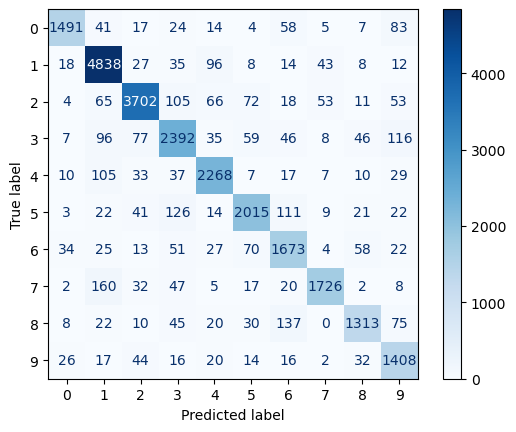

In [29]:
# Model evaluation
def evaluate(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    accuracy = correct / total
    return accuracy, all_labels, all_preds

# Evaluate the model
accuracy, all_labels, all_preds = evaluate(model, test_loader, device)
print(f"Test Accuracy: {accuracy:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap=plt.cm.Blues)
plt.show()